# Reconaissance des régions actives et structures



In [637]:
from module import readFitsBz2

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.map
import sunpy.sun
from sunpy.coordinates import frames


In [679]:

# 'data/L2/imoa_03933_l2_20220326_13422771_emi1.fts.bz2'
# 'data/L2/imoa_03933_l2_20230323_09150652_emi1.fts.bz2'
# 'data/L2/imoa_03933_l2_20240228_12402419_emi1.fts.bz2'
# 'data/L2/imoa_03933_l2_20240228_14452489_emi1.fts.bz2'


hdu = readFitsBz2('data/L2/imoa_03933_l2_20200228_08560700_emi1.fts.bz2')


coord = SkyCoord(0*u.arcsec, 0*u.arcsec, obstime=hdu.header['DATE_OBS'],
                observer='earth', frame=frames.Helioprojective, )
    
scale = [0.5*(hdu.header['NAXIS1']-100)/hdu.header['RSUN_OBS'], 0.5*(hdu.header['NAXIS2']-100)/hdu.header['RSUN_OBS']]
header = sunpy.map.make_fitswcs_header(hdu.data, coord,
                                    reference_pixel=[hdu.header['CRPIX1'], hdu.header['CRPIX2']]*u.pixel,
                                    scale=scale*u.arcsec/u.pixel,
                                    )

map = sunpy.map.Map(hdu.data, header)

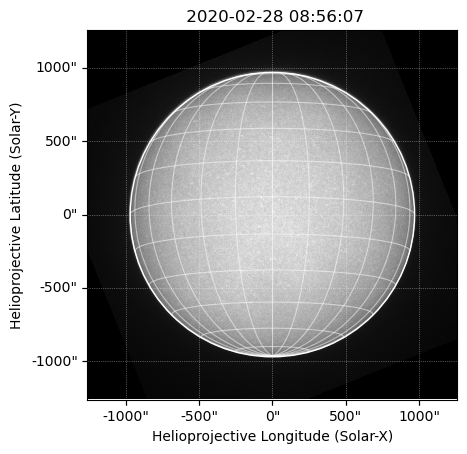

In [680]:
fig = plt.figure()
ax = fig.add_subplot(projection=map)
map.plot(axes=ax)
map.draw_limb(axes=ax)
map.draw_grid(axes=ax)
plt.show()

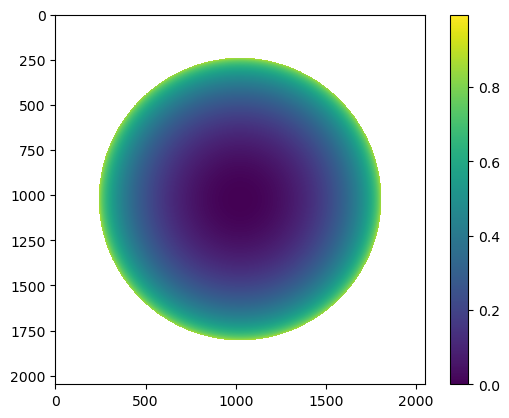

In [681]:
coordinates = sunpy.map.all_coordinates_from_map(map)
weights = coordinates.transform_to("heliocentric").z.value

mu = (weights / np.nanmax(weights))

weights = np.ones(mu.shape) - mu

#weights[np.isnan(weights)] = 0

fig, ax = plt.subplots()
im = ax.imshow(weights)
fig.colorbar(im)

plt.show()

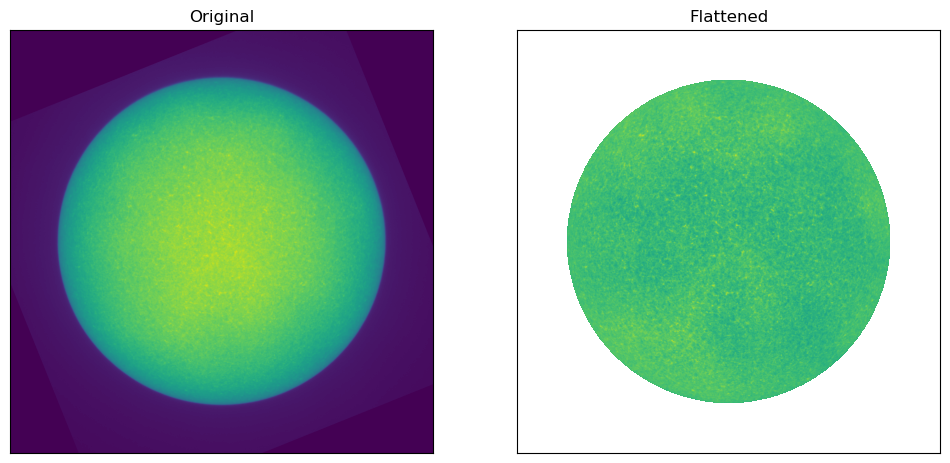

In [682]:
flattened = map.data + 8800*weights

plt.figure(figsize=(12,12))
plt.subplot(121),plt.imshow(hdu.data, origin='lower')
plt.title('Original'), plt.xticks([]), plt.yticks([]);
plt.subplot(122),plt.imshow(flattened, origin='lower')
plt.title('Flattened'), plt.xticks([]), plt.yticks([]);

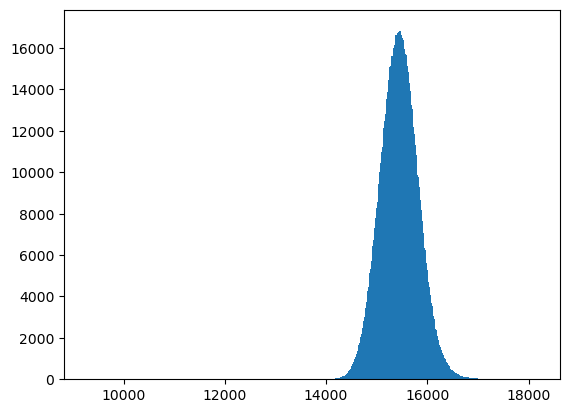

In [683]:
plt.hist(flattened.flatten(), bins='auto');

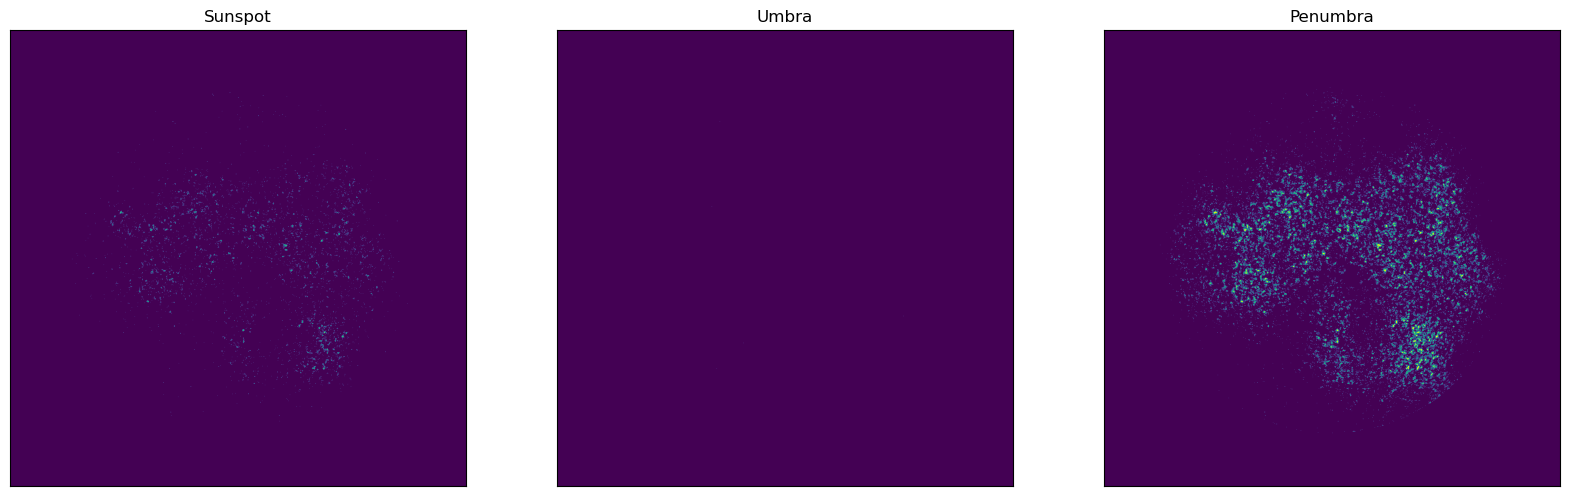

In [684]:
ret, umbra = cv.threshold(flattened,0.7*np.nanmedian(flattened),255,cv.THRESH_BINARY_INV)
ret, sunspot = cv.threshold(flattened,0.94*np.nanmedian(flattened),255,cv.THRESH_BINARY_INV)
ret, penumbra = cv.threshold(flattened,0.96*np.nanmedian(flattened),255,cv.THRESH_BINARY_INV)

plt.figure(figsize=(20,20))
plt.subplot(131),plt.imshow(sunspot, origin='lower')
plt.title('Sunspot'), plt.xticks([]), plt.yticks([]);
plt.subplot(132),plt.imshow(umbra, origin='lower')
plt.title('Umbra'), plt.xticks([]), plt.yticks([]);
plt.subplot(133),plt.imshow(penumbra, origin='lower')
plt.title('Penumbra'), plt.xticks([]), plt.yticks([]);


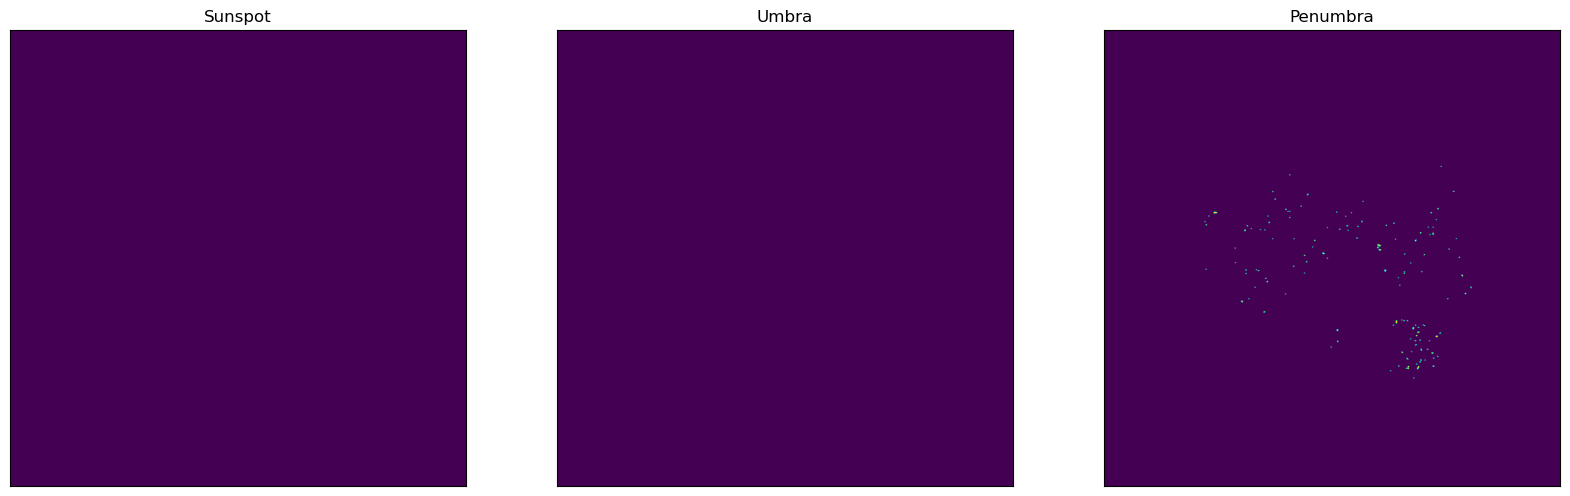

In [685]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
umbra = cv.morphologyEx(umbra.astype(np.uint8), cv.MORPH_OPEN, kernel)
cv.circle(umbra, (1024,1024), int(hdu.header['rsun_obs']),color=(0,0,0), thickness = 50);

kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
sunspot = cv.morphologyEx(sunspot.astype(np.uint8), cv.MORPH_OPEN, kernel)
cv.circle(sunspot, (1024,1024), int(hdu.header['rsun_obs']),color=(0,0,0), thickness = 50);

kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
penumbra = cv.morphologyEx(penumbra.astype(np.uint8), cv.MORPH_OPEN, kernel)
cv.circle(penumbra, (1024,1024), int(hdu.header['rsun_obs']),color=(0,0,0), thickness = 50);

plt.figure(figsize=(20,20))
plt.subplot(131),plt.imshow(sunspot, origin='lower')
plt.title('Sunspot'), plt.xticks([]), plt.yticks([]);
plt.subplot(132),plt.imshow(umbra, origin='lower')
plt.title('Umbra'), plt.xticks([]), plt.yticks([]);
plt.subplot(133),plt.imshow(penumbra, origin='lower')
plt.title('Penumbra'), plt.xticks([]), plt.yticks([]);

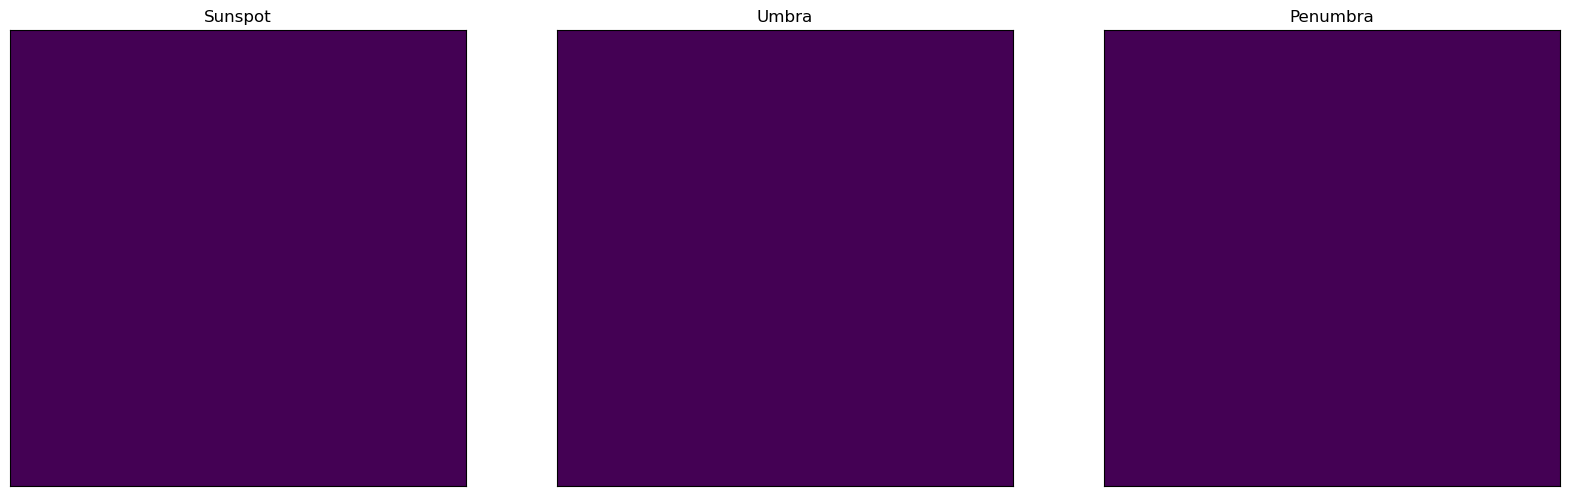

In [686]:
n_labels, labels = cv.connectedComponents(penumbra, connectivity=8)

keep_label_list = np.unique(cv.bitwise_and(labels,sunspot.astype(np.int32)))
mask = np.isin(labels, keep_label_list)

penumbra[~mask] = 0

plt.figure(figsize=(20,20))
plt.subplot(131),plt.imshow(sunspot, origin='lower')
plt.title('Sunspot'), plt.xticks([]), plt.yticks([]);
plt.subplot(132),plt.imshow(umbra, origin='lower')
plt.title('Umbra'), plt.xticks([]), plt.yticks([]);
plt.subplot(133),plt.imshow(penumbra, origin='lower')
plt.title('Penumbra'), plt.xticks([]), plt.yticks([]);

## Label

In [687]:
img = cv.convertScaleAbs(hdu.data, alpha=(255.0/65535.0)).astype(np.uint8)

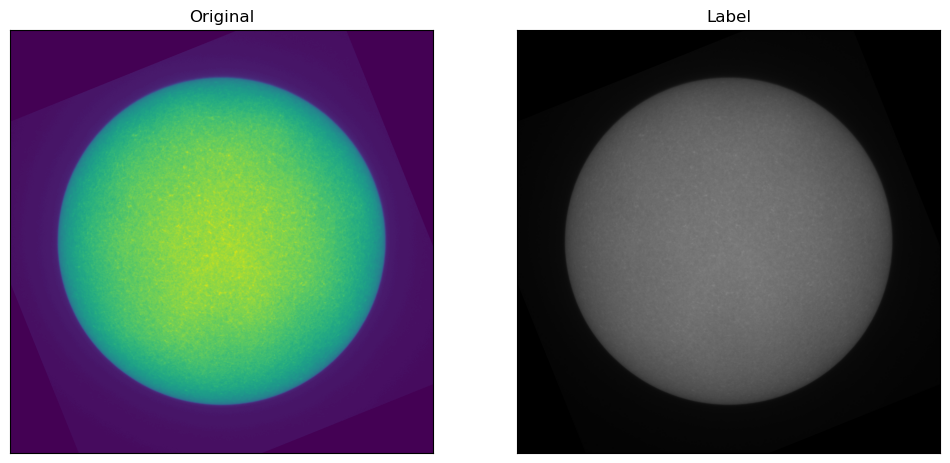

In [688]:
n_labels, labels, stats, centroids = cv.connectedComponentsWithStats(penumbra, connectivity=8)

colors = np.random.randint(0, 255, size=(n_labels , 3), dtype=np.uint8)
colors[0] = [0, 0, 0]
false_colors = colors[labels]

img_label = cv.addWeighted(cv.cvtColor(img, cv.COLOR_GRAY2RGB),2,false_colors,0.4,0)

plt.figure(figsize=(12,12))
plt.subplot(121), plt.imshow(img, origin='lower');
plt.title('Original'), plt.xticks([]), plt.yticks([]);
plt.subplot(122), plt.imshow(img_label, origin='lower');
plt.title('Label'), plt.xticks([]), plt.yticks([]);

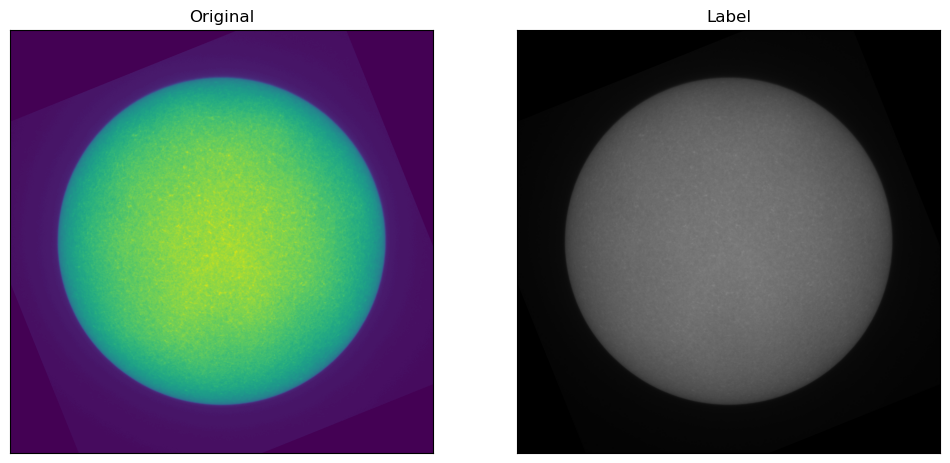

In [689]:
img_lab = img_label
contours, hierarchy = cv.findContours(umbra, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(img_lab, contours, -1, (0,0,200), 1)

contours, hierarchy = cv.findContours(penumbra, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(img_lab, contours, -1, (200,0,0), 1)

plt.figure(figsize=(12,12))
plt.subplot(121), plt.imshow(img, origin='lower');
plt.title('Original'), plt.xticks([]), plt.yticks([]);
plt.subplot(122), plt.imshow(img_lab, origin='lower');
plt.title('Label'), plt.xticks([]), plt.yticks([]);

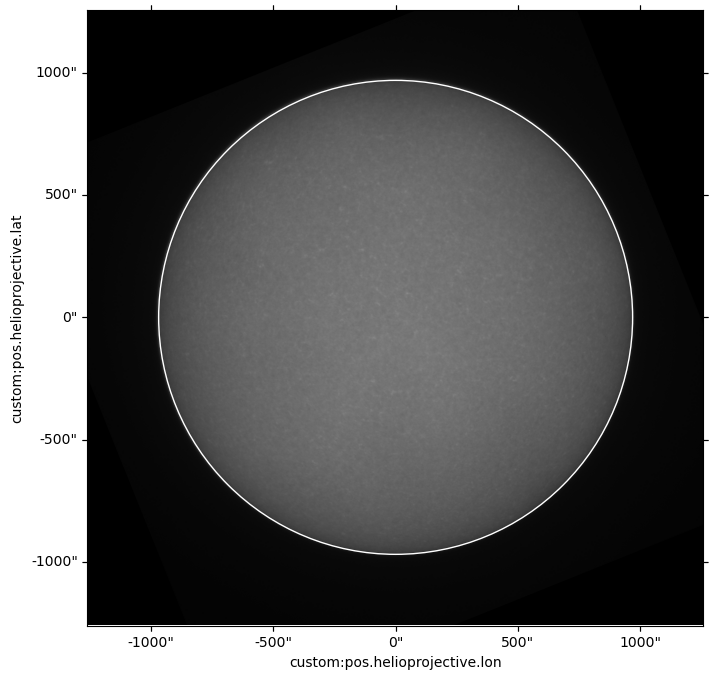

In [690]:

img_idlab = img_lab.copy()

font = cv.FONT_HERSHEY_SIMPLEX 

fontScale = 1

color = (0, 255, 0) 

thickness = 2

for idx in range(1,n_labels):
    x,y,w,h = cv.boundingRect((labels==idx).astype(np.uint8))
    img_idlab = cv.putText(img_idlab, f'{idx}', (x-10, y+h+10), font,  
                fontScale, color, thickness, cv.LINE_AA, True)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=map)
plt.imshow(img_idlab, origin='lower');
map.draw_limb(axes=ax)

plt.show()

## Area

"A simple ratio of pixels contained in each sunspot to the total number of pixels on the disk of the sun gives the relative size of the sunspot to the solar disk. This value is then multiplied by $1 × 10^6$ to put the value in millionths of a solar hemisphere and finally divided by the cosine of the angle of the sunspot off the center of the solar disk, which is the same 𝜇 from equation 4 from Section 3.2. , since objects near the limb of the Sun appear smaller than objects toward the center of the solar disk. The combined equation for the area calculation is given as :

$$Area = \frac{A}{2\pi r^2} \frac{1 \times 10^6}{\mu}$$

Where 𝐴 is the number of pixels contained by the analyzed sunspot and 𝑟 is the radius of
the sun in pixels from the edge detection algorithm." [1]

MoSH : Millionths of Solar Hemisphere


In [691]:
r = hdu.header['RSUN_OBS']

label = 3
centroid = centroids[label].astype(np.uint16)
area = (np.sum(labels==label) / (2*np.pi*r**2)) * (10**6 / mu[centroid[1],centroid[0]])

plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(img_idlab[centroid[1]-100:centroid[1]+100, centroid[0]-100:centroid[0]+100], origin='lower');
plt.title(f'Area : {area:.2f} MoSH'), plt.xticks([]), plt.yticks([]);
plt.subplot(122)
plt.imshow(img[centroid[1]-100:centroid[1]+100, centroid[0]-100:centroid[0]+100], origin='lower');
plt.title('Original'), plt.xticks([]), plt.yticks([]);

IndexError: index 3 is out of bounds for axis 0 with size 1

## Tracking

Rotation model : Howard

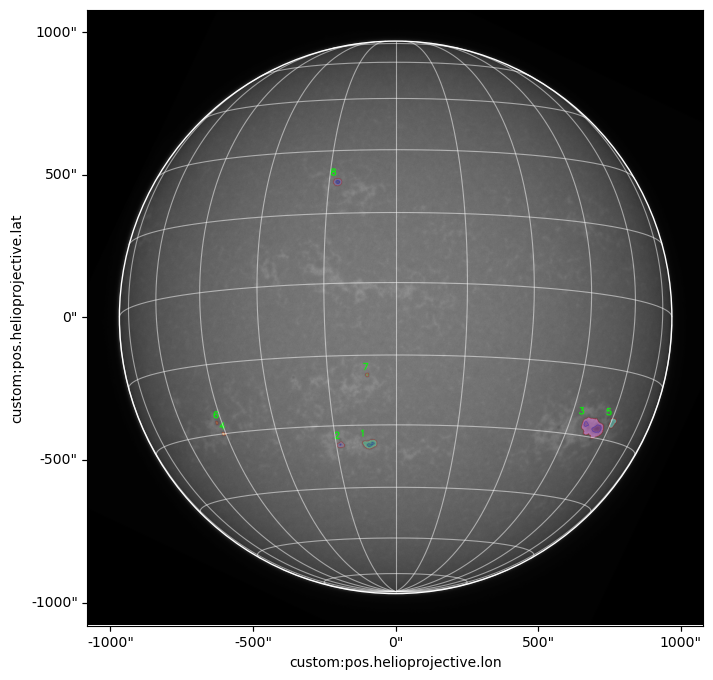

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=map)
plt.imshow(img_idlab, origin='lower');
map.draw_limb(axes=ax)
map.draw_grid(axes=ax)

plt.show();

In [ ]:
from sunpy.coordinates import RotatedSunFrame
from module import toSunpyMap

map2 = toSunpyMap('data/L2/imoa_03933_l2_20240229_10402467_emi1.fts.bz2')

label = 

point = map.pixel_to_world(centroids[label][0]*u.pixel, (centroids[label][1])*u.pixel)

durations = 20 * u.hour
diffrot_point = SkyCoord(RotatedSunFrame(base=point, rotated_time=map2.date))

transformed_diffrot_point = diffrot_point.transform_to(map.coordinate_frame)

fig = plt.figure()
ax = fig.add_subplot(projection=map)
map.plot(axes=ax)
map.draw_limb(axes=ax)
map.draw_grid(axes=ax)
ax.plot_coord(point, 'r.', fillstyle='full', label='Original')
ax.plot_coord(transformed_diffrot_point, 'b.', fillstyle='full', label='Rotated')
ax.legend(loc='upper right')

plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection=map2)
map2.plot(axes=ax)
map2.draw_limb(axes=ax)
map2.draw_grid(axes=ax)
ax.plot_coord(point, 'r.', fillstyle='full', label='Original')
ax.plot_coord(transformed_diffrot_point, 'b.', fillstyle='full', label='Rotated')
ax.legend(loc='upper right')

plt.show()

SyntaxError: invalid syntax (735505832.py, line 6)

**Ressources :** 

[1] Townsend, MacLane A., "Automated Sunspot Classification and Tracking Using SDO/HMI Imagery" (2016). Theses and Dissertations.
349.
https://scholar.afit.edu/etd/349